# Practice Session 1: Policy and Value Iteration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rlsummerschool/practical-sessions/blob/master/notebooks/DP_practice.ipynb)

In [1]:
# Set up the environment (not needed for local installations)
!pip install "git+https://github.com/rlsummerschool/practical-sessions.git" --quiet

import time
import random

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 21.9 MB/s eta 0:00:00


## RL development in Python

Large RL projects are usually developed locally, as any other Python package, in OOP, version controlled by Git (see [example](https://github.com/rlsummerschool/practical-sessions/blob/master/rlss_practice/environments.py)).

[Jupyter](https://jupyter.org/) notebooks, like this one, are collections of text cells and code cells, that can be executed with an interactive interpreter.
Colab notebooks are Jupyter notebooks whose interpreter runs in a runtime that is hosted by Google.

### Environments and tasks

An MDP is a model of Reinforcement Learning tasks. It comprises of:
* a **state space** $\mathcal{S}$
* a **action space** $\mathcal{A}$
* a **starting-state distribution** $\nu_0(s)$
* a **reward function** $r: \mathcal{S}\times\mathcal{A}\rightarrow [0,1]$ (or vector $r\in[0,1]^{|\mathcal{S}|\cdot|\mathcal{A}|}$)
* a **transition function** $p: \mathcal{S}\times\mathcal{A}\rightarrow \Delta_{\mathcal{S}}$ (or matrix $p \in\mathbb{R}^{|\mathcal{S}|\cdot|\mathcal{A}|\times|\mathcal{S}|}$)

where $\Delta_{\mathcal{S}} = \{q\in\mathbb{R}^{|\mathcal{S}|} \,\,|\,\, \sum_{s\in\mathcal{S}}q(s) = 1,\, q(s)\geq 0 \text{ for } s\in\mathcal{S}\}$

Interaction between an agent (or decision maker) and some environment (or task) in some round $t$:

<div>
<img src="https://drive.google.com/uc?export=view&id=11KyhHxuaileBEJ9fFZmIS5-GzncQgyqt" alt="agent-environment interaction" width="600"/>
</div>

The agent is equipped with a policy $\pi$ mapping states to actions (or a distribution over actions).

### The Gym(nasium) interface

[Gymnasium](https://gymnasium.farama.org/) is a standard API for Decision Processes, based on OpenAI's Gym library.

In [2]:
# Standard import
import gymnasium as gym
from gymnasium import Env

pygame 2.4.0 (SDL 2.26.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


The library also defines a number of classic benchmarks [Atari](https://gymnasium.farama.org/environments/atari/) games, [MuJoCo](https://gymnasium.farama.org/environments/mujoco/) simulations, and [ToyText](https://gymnasium.farama.org/environments/toy_text/), minimal environments for debugging.


In [3]:
# A registered environment (for example Cliff Walking) can be instantiated with
env = gym.make("CliffWalking-v0")

# Important properties:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


We only consider discrete state and action spaces. See the possible alternatives: `dir(gym.spaces)`

Environments can be fully observable, partially observable or non-stationary. All these variants fit the same environment interface.
We should know which class our environment belongs to.
Today, we only consider stationary and fully observable MDPs.

The environment interface allows  to sample initial states and transition with `env.reset()` and `env.step(action)`. Every method is well documented (see `help(gym.Env.step)`).

Try it out!

In [4]:
observation, info = env.reset()
print(f"Initial observation: {observation}")

action = 0  # any action

observation, reward, terminated, truncated, info = env.step(action)
print(f"Observation: {observation}, reward {reward}")

observation, reward, terminated, truncated, info = env.step(action)
print(f"Observation: {observation}, reward {reward}")

observation, reward, terminated, truncated, info = env.step(action)
print(f"Observation: {observation}, reward {reward}")

Initial observation: 36
Observation: 24, reward -1
Observation: 12, reward -1
Observation: 0, reward -1


Custom environments can be created by subclassing the `Env` class.

Environments can be also modified with wrappers. See the predefined Gymnasium [Wrappers](https://gymnasium.farama.org/api/wrappers/#gymnasium-wrappers).

## Setting up our RL task



We experiment with a simple grid-world environment, based on the implementation in [minigrid](https://minigrid.farama.org/environments/minigrid/). The environment is configured and observations are transformed appropriately (you already know how).

In [5]:
from rlss_practice.environments import Room, MinigridBase


# Initializing the environment
env = Room(
    failure=0.0,
    agent_start_pos=(1, 1),
    agent_start_dir=0,
    size=5,
)
print(env)

WWWWW
W>  W
W   W
W  GW
WWWWW


In this ASCII representation, > is the agent, facing right, G is the goal, and W are walls.

Understand you own environment:

In [6]:
print("Action space:", env.action_space)
print("Observation space:", env.observation_space, end="\n\n")
#print(help(MinigridBase))

Action space: Discrete(3)
Observation space: MultiDiscrete([5 5 4])



When you checkout `help(env)`:

    class MinigridBase
       MinigridBase(minigrid: minigrid.minigrid_env.MiniGridEnv, seed: int, failure=0.0)

       Base class for minigrid environments with explicit transition and reward functions.

       The agent is rewarded upon reaching the goal location.

       Action space:

       | Num | Name         | Action       |
       |-----|--------------|--------------|
       | 0   | left         | Turn left    |
       | 1   | right        | Turn right   |
       | 2   | forward      | Move forward |

       Observation space:

       | Name | Description             |
       |------|-------------------------|
       | x    | x coordinate            |
       | y    | y coordinate (downward) |
       | dir  | cardinal direction      |

       The transition function is stored in `T`,
       where `T[state][action][next_state]` is the transition probability.
       The reward function is `R`. `R[state][action]` contains a reward.

### Demo

Here's a rollout loop, for a single trajectory

In [7]:
# Test it
done = False
observation, info = env.reset()
print("Initial observation:", observation)
print(env)

# Steps
while not done:

    try:
      # Action selection

      action = int(input("Action: "))

      # Transition
      observation, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated

      print(f"Observation: {observation}, reward {reward}, terminated {terminated}, truncated {truncated}")
      print(env)

    except:
      done = True
      print("Invalid action or KeyboardInterrupt")


Initial observation: [1 1 0]
WWWWW
W>  W
W   W
W  GW
WWWWW
Action: 1
Observation: [1 1 1], reward 0.0, terminated False, truncated False
WWWWW
WV  W
W   W
W  GW
WWWWW
Action: 2
Observation: [1 2 1], reward 0.0, terminated False, truncated False
WWWWW
W   W
WV  W
W  GW
WWWWW
Action: 1
Observation: [1 2 2], reward 0.0, terminated False, truncated False
WWWWW
W   W
W<  W
W  GW
WWWWW
Invalid action or KeyboardInterrupt


We can define a function that performs `n_trajectories` rollouts on the environment with a given policy. We can also compute arbitrary statistics in the meanwhile.

In [8]:
def rollouts(env, policy, n_trajectories, gamma):
    """Execute policy over env for n_trajectories and compute discounted return."""
    total_return = 0.0

    # Trajectores
    for _ in range(n_trajectories):

        # Init
        discount = 1.0
        ret = 0.0
        observation, info = env.reset()
        done = False

        # Steps
        while not done:

            # Action selection
            action = policy(observation)

            # Transition
            observation, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated
            ret += reward * discount
            discount *= gamma

            if done:
                total_return += ret

    env.close()
    return total_return / n_trajectories

Since we don't have a policy yet, let's define the uniform one.

In [9]:
class UniformPolicy():
    def __init__(self, n_actions: int):
        self.n_actions = n_actions

    def __call__(self, observation):
        return random.randint(0, self.n_actions-1)

Let's try:

In [10]:
avg_return = rollouts(env=env,
                      policy=UniformPolicy(env.action_space.n),
                      n_trajectories=20,
                      gamma=0.9)

print(avg_return)

0.06171285861857455


We can also visualize the execution:

In [11]:
from rlss_practice.wrappers import Renderer
visible_env = Renderer(env)

In [12]:
avg_return = rollouts(env=visible_env,
                      policy=UniformPolicy(env.action_space.n),
                      n_trajectories=1,
                      gamma=0.9)

print(avg_return)

0.0


In [13]:
visible_env.play()

Finally, a small utility for creating callable objects from state-action mappings

In [14]:
def make_policy(policy_dict):
  """Return the policy dictionary as a callable object"""

  def callable_policy(observation):
      return policy_dict[tuple(observation.tolist())]

  return callable_policy

### Explicit model

The algorithms we will implement require that a complete model of the environment is available, in the form of explicit transition and reward functions. This is not part of the gym interface.

These two functions are stored in two members:

In [15]:
# Transition and reward functions
T = env.T
R = env.R

# These are represented as dictionaries (for maximum clarity)
#   and indexed as T[state][action][next_state]
print("A few probabilities")
print(T[(1, 1, 0)][2][(2, 1, 0)])
print(T[(1, 1, 0)][2][(1, 1, 1)])
print(T[(3, 1, 0)][1][(3, 1, 1)])

#   also R[state][action]
print("\nA few rewards")
print(R[(1, 1, 0)][2])
print(R[(3, 3, 0)][0])

A few probabilities
1.0
0.0
1.0

A few rewards
0.0
1.0


In [ ]:
#env.pretty_print_T()

In [16]:
# Explicit set of states and actions

print("States", env.states)
print("Actions", env.actions)
print("Number of states", len(env.states))
print("Number of actions", len(env.actions))

States [(1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 3, 0), (3, 3, 1), (3, 3, 2), (3, 3, 3), (0, 0, 0)]
Actions [0, 1, 2]
Number of states 37
Number of actions 3


In [17]:
# Some classic imports for the rest of the notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

mpl.style.use('seaborn-v0_8')

## Solving the Minigrid task

We would like to find a **stationary deterministic memoryless policy** or mapping from states to actions $\pi : \mathcal{S}\rightarrow \mathcal{A}$, that is able to arrive at the **goal state** sooner.

In other words, our objective is to find $\pi$ which maximizes the **expected discounted return** from any starting state represented by:

\begin{align*}
    \rho(\pi) &= \mathbb{E}_{s_0\sim\nu_0, s_{t+1}\sim p(\cdot|s_t,\pi(s_t))}\left[\sum_{t=0}^\infty\gamma^t r(s_t,\pi(s_t))\right]\\
    &= \sum_{s}\nu_0(s) V^{\pi}(s)
\end{align*}

with the **discount factor** $\gamma\in[0,1)$.


&nbsp;

---

&nbsp;

Recall that the **state value function** for $s\in \mathcal{S}$ denoted

\begin{align*}
    V^\pi(s) &= \mathbb{E}_{s_{t+1}\sim p(\cdot|s_t,\pi(s_t))}\left[\sum_{t=0}^\infty\gamma^t r(s_t,\pi(s_t))\bigg|s_0=s\right]\\
    &=  \sum_{a}\pi(a|s)Q^{\pi}(s,a)
\end{align*}

represents the value of being in state $s$ and following policy $\pi$ while the **action-value function** for $s\in \mathcal{S}, a\in \mathcal{A}$ denoted

$$ Q^\pi(s,a) = r(s,a) + \gamma\sum_{s'\in\mathcal{S}}p(s'|s,a)V^{\pi}(s')$$

is the value of first taking an action $a$ in state $s$ then following policy $\pi$.

By standard notation, the **Bellman operator** of policy $\pi$ acting on functions $V : \mathcal{S}\rightarrow \mathbb{R}$ (or vectors $V\in\mathbb{R}^{|\mathcal{S}|}$) is given as:

$$(T^{\pi}V)(s) =  \sum_{a}\pi(a|s)\bigg[r(s,a) + \gamma\sum_{s'\in\mathcal{S}}p(s'|s,a)V(s')\bigg],\quad s\in\mathcal{S}$$


&nbsp;

---

&nbsp;

Ideally, we would like to find an **optimal policy** $\pi^*$ with:

$$ \pi^*(s) \in \underset{a\in\mathcal{A}}{\arg\max} \bigg\{r(s,a) + \gamma\sum_{s'\in\mathcal{S}}p(s'|s,a)V^{\pi^*}(s')\bigg\},\quad s\in\mathcal{S}$$

that maximizes our immediate reward and future return.

The Bellman operator of $\pi^*$ (a.k.a the **Bellman optimality operator**) acting on functions $V : \mathcal{S}\rightarrow \mathbb{R}$ (or vectors $V\in\mathbb{R}^{|\mathcal{S}|}$) is given as:

$$(T^{*}V)(s) =  \max_{a}\bigg\{r(s,a) + \gamma\sum_{s'\in\mathcal{S}}p(s'|s,a)V(s')\bigg\},\quad s\in\mathcal{S}$$


&nbsp;

---

&nbsp;

With the transition and reward function of the grid-world task available to us, we attempt to find an optimal policy via **Dynamic programming**. Precisely, we implement **Policy Iteration** and **Value iteration** methods introduced in the first lecture.

&nbsp;

### Notation

*   $r_{\pi}\in\mathbb{R}^{|\mathcal{S}|}$ so that for $s\in\mathcal{S}$, $r_{\pi}(s) = r(s,\pi(s))$.
*   $p_{\pi}\in\mathbb{R}^{|\mathcal{S}|\times|\mathcal{S}|}$ so that for $s,s'\in\mathcal{S}$, $p_{\pi}(s'|s) = p(s'|s,\pi(s))$.
*   $\sum_{r}p(s',r|s,a)  = p(s'|s,a)r(s,a)$ since rewards are deterministic.
*   $n_{k}$ is the number of loops required to compute $V_{k}$
*   $\Delta$ is a threshold on the accuracy of value estimation [[3]](#scrollTo=XqJPFe6f6gFV&line=5&uniqifier=1)

&nbsp;

### Policy Iteration (PI) Recap

**Idea**

Gradually advance to $\pi^{*}$ from an initial guess $\pi_0$ through a series of **policy evaluation** and **policy improvement** steps.

&nbsp;

**Policy Evaluation step**

Given a policy $\pi_k$, compute $V^{\pi_k}$ as

* $V^{\pi_k} = (I - \gamma\, p_{\pi_k})^{-1}r_{\pi_k}$

&nbsp;

**Policy Improvement step**

Obtain $\pi_{k+1}$ as the greedy policy w.r.t $V^{\pi_k}$ (or $V_{k}$). That is,
$$ \pi_{k+1}(s) \in \underset{a\in\mathcal{A}}{\arg\max} \bigg\{r(s,a) + \gamma\sum_{s'\in\mathcal{X}}p(s'|s,a)V^{\pi_{k}}(s')\bigg\},\quad s\in\mathcal{S}$$

&nbsp;

#### Putting everything together

Starting from an arbitrary stationary deterministic markovian policy $\pi_{0}$, for $k = 0,1,2,\cdots, K$ do:
* Compute $V^{\pi_k}$
* Obtain $\pi_{k+1}$ as the greedy policy w.r.t $V^{\pi_k}$
* Terminate loop if policy is stable (i.e $\pi_{k+1}(s) = \pi_{k}(s)$ for all $s\in\mathcal{S}$) and return $\pi_{k+1}$.



&nbsp;

#### Theoretical guarantee [[1,2]](#scrollTo=XqJPFe6f6gFV&line=5&uniqifier=1)

PI finds an optimal policy after $K = \mathcal{\tilde{O}}(\mathcal{SA}/(1-\gamma))$ iterations.

<!---
Explicitly $K = \mathcal{\tilde{O}}((\mathcal{SA - S})/(1-\gamma))$ iterations.
-->

In [18]:
# Don't look at the solutions! This module contains the functions you should write
from rlss_practice import dp_solutions

In [37]:
class PolicyIteration:
  """
  Implements policy iteration
  """
  def __init__(self, env: Env, gamma: float, initial_policy = None):
    # Store
    self.env = env
    self.states = self.env.states
    self.n_states = len(self.states)
    self.actions = self.env.actions
    self.n_actions = len(self.actions)
    self.gamma = gamma
    self.policy = initial_policy

    # Default policy
    if self.policy == None:
      np.random.seed(4)
      self.policy = {state: np.random.randint(0, self.n_actions-1) for state in self.states}

    self.policy_stable = False
    self.V = {state: 0.0 for state in env.states}
    self.V_logs = []

  def _evaluate_policy(self):
    """
    Given 'policy' π_{k} compute V^{π_{k}}. Let,

      A = (I - \gamma p_{π_{k}})
      b = r_{π_{k}}
      x = V^{π_{k}}

    solve the system of linear equations Ax=b

    :return x: a |S|x1 array
    """
    # Task: complete this and return x instead of using the line "return dp_solutions..."
    A = np.identity(len(self.states)) - self.gamma * self.get_p_pi()
    b = self.get_r_pi()

    return np.linalg.solve(A,b)


  def evaluate_policy(self):
    """
    Collect state values in dict
    """
    V_array = self._evaluate_policy()

    # Assign values to holder as dictionary
    self.V = {state: V_array[i].item() for i, state in enumerate(self.states)}

    # Append values to log for plots
    self.V_logs.append(self.V.copy())


  def get_policy(self):
    """
    Get the greedy policy:

      π_{k+1}(s) = argmax_{a\in A} Q^{\pi_{k}}(s,a)

    where

      Q^{\pi_{k}}(s,a) = r(s,a) + gamma * <P(.|s,a),V^{\pi_{k}}>

    assign new policy to self.policy
    update self.policy_stable
    """
    self.policy_stable = True
    for state in self.states:
      best_q = -np.inf
      tmp_a = self.policy[state]
      best_a = 0
      for action in self.actions:
        q = self.get_expected_update(state, action)
        if q > best_q:
          best_q = q
          best_a = action
      self.policy[state] = best_a
      if self.policy[state] != tmp_a:
        self.policy_stable = False




  def get_expected_update(self, state, action):
    """
    Compute:

      Q(s,a) = r(s,a) + gamma <p(.|s,a),V>

    :param state
    :param action

    :return Q(s,a): float
    """
    # TODO: Solve this and return Q(s,a) instead
    dot_product = sum([self.V[state_next] * self.env.T[state][action][state_next] for state_next in self.states])
    return self.env.R[state][action] + self.gamma * dot_product


  def get_p_pi(self):
    """
    Given π_{k}, compute p_{π_{k}}
    """
    p_pi = np.zeros((self.n_states,self.n_states))

    for s_index, s in enumerate(self.states):
      for snext_index, snext in enumerate(self.states):
        p_pi[s_index, snext_index] = self.env.T[s][self.policy[s]][snext]

    return p_pi


  def get_r_pi(self):
    """
    Given π_{k}, compute r_{π_{k}}
    """
    r_pi = np.zeros((self.n_states,1))

    for i, state in enumerate(self.states):
      r_pi[i][0] = self.env.R[state][self.policy[state]]

    return r_pi

Let's try it out

In [38]:
# Run policy iteration
PI_planner1 = PolicyIteration(env, gamma=0.9)

while not PI_planner1.policy_stable:
  PI_planner1.evaluate_policy()
  PI_planner1.get_policy()

Visualization

In [39]:
def visualize(vlogs, state, grid_size):
  grid_size -= 2   # walls

  # Initial state values
  fig1 = plt.figure(figsize=(4, 3))
  ax1 = fig1.subplots()
  ax1.set_ylabel("value of (1,1,0)")
  ax1.set_xlabel("iterations")
  initial_state_values = [value[(1, 1, 0)] for value in PI_planner1.V_logs]
  ax1.plot(range(len(initial_state_values)), initial_state_values)

  # States values over time
  some_values_over_time = [
    {(x, y): values[(x, y, o)] for (x, y, o) in env.states if o == 0}  # o is a fixed agent orientation
    for values in vlogs
  ]
  values_over_time = [
    np.array([[values[(x+1, y+1)] for x in range(grid_size)] for y in range(grid_size)])
    for values in some_values_over_time
  ]
  vmids = [(values.max() + values.min()) / 2 for values in values_over_time]
  vmin = min([values.min() for values in values_over_time])
  vmax = max([values.max() for values in values_over_time])

  steps = len(values_over_time)
  fig2 = plt.figure(figsize=(4 * steps, 3))
  axs2 = fig2.subplots(1, steps)
  if isinstance(axs2, plt.Axes):
    axs2 = [axs2]
    multistep = False
  else:
    multistep = True

  for i, ax in enumerate(axs2):
    ax.set_title(f"values at step {i}" if multistep else "values")
    ax.imshow(values_over_time[i], cmap="Blues", vmin=vmin, vmax=vmax)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for x in range(grid_size):
      for y in range(grid_size):
        val = values_over_time[i][y,x]
        ax.text(x, y, f"{val:.2f}", ha="center", va="center", color="w" if val > vmids[i] else "k")

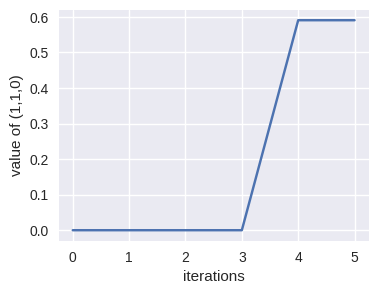

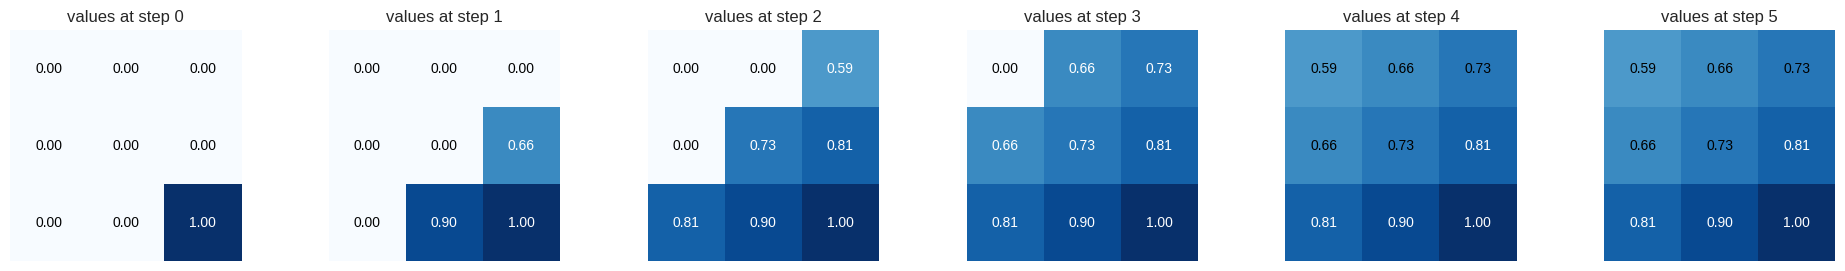

In [40]:
visualize(PI_planner1.V_logs, (1, 1, 0), 5)

We can also test the policy.

In [41]:
avg_return = rollouts(env=visible_env,
                      policy=make_policy(PI_planner1.policy),
                      n_trajectories=20,
                      gamma=0.9)

print(avg_return)

0.5904900000000003


In [42]:
visible_env.play()

What if we have failure probabilities now?

In [43]:
# Define
env = Room(
    failure=0.2,
    agent_start_pos=(1, 1),
    agent_start_dir=1,
    size=6,
)
visible_env = Renderer(env)
print(env)

# Plan
PI_planner1 = PolicyIteration(env, gamma=0.9)

while not PI_planner1.policy_stable:
  PI_planner1.evaluate_policy()
  PI_planner1.get_policy()

WWWWWW
WV   W
W    W
W    W
W   GW
WWWWWW


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/videos-dir folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
# Visualize
avg_return = rollouts(
    env=visible_env,
    policy=make_policy(PI_planner1.policy),
    n_trajectories=80,
    gamma=0.9
)
print(avg_return)

In [ ]:
visible_env.play()

visualize(PI_planner1.V_logs, (1, 1, 1), 6)

But matrix inversions can be quite expensive. Consider iterative policy evaluation instead.

&nbsp;

### Modified Policy Iteration (MPI) Recap

**Idea**

Same as PI but with **truncated policy evaluation**

&nbsp;

**Truncated Policy Evaluation step**

Given a policy $\pi_k$, estimate $V^{\pi_k}$ as $V_{k}$ with the following iterations

  * Initialize $V$ as $\mathbf{0}$ when $k = 0$ and $V_{k-1}$ otherwise, let $\pi = \pi_k$

    <div>
    <img src="https://drive.google.com/uc?export=view&id=1QaMg7a6HELjYycAnm6RE9vnzHD_fnaCn" alt="iterative policy evaluation" width="600"/>
    </div>

    Return $V_k = V$. <!--$(T^{\pi_{k}})^{n_{k}}V_{k-1}$-->

&nbsp;

#### Putting everything together

Starting from an arbitrary stationary deterministic markovian policy $\pi_{0}$, for $k = 0,1,2,\cdots, K$ do:
* Estimate $V^{\pi_k}$ with $V_{k}=(T^{\pi_{k}})^{n_{k}}V_{k-1}$
* Obtain $\pi_{k+1}$ as the greedy policy w.r.t $V^{\pi_k}$
* Terminate loop if policy is stable (i.e $\pi_{k+1}(s) = \pi_{k}(s)$ for all $s\in\mathcal{S}$) and return $\pi_{k+1}$.

In [44]:
class ModifiedPolicyIteration(PolicyIteration):
  """
  Implements policy iteration with truncated policy evaluation
  """
  def __init__(self,
              env: Env,
              gamma: float,
              theta: float,
              initial_policy = None):

    super().__init__(env, gamma, initial_policy)
    self.theta = theta
    self.V = {state: 0.0 for state in env.states}


  def evaluate_policy(self):
    """
    Given 'policy' π_{k},
    Starting from a previous guess 'V_{k-1}',
    iteratively estimate V^{π_{k}} as T^{π_{k}}V_{k-1}.

    assign new state values to self.V
    """
    # Task: Complete this and delete line *

    # Set Delta
    delta = np.inf

    # Main loop for iterative value update
    while delta > self.theta:
      # Initialize Delta
      delta = 0
      for state in self.states:
        v = self.V[state]
        sum_ = 0
        for s_next in self.states:
          sum_ += self.env.T[state][self.policy[state]][s_next] * (self.env.R[state][self.policy[state]] + self.gamma * self.V[s_next])
        self.V[state] = sum_
        delta = max(delta, abs(v - self.V[state]))
      # ToDo: Loop over states

        #ToDo: Update the state value

        #ToDo: Update Delta

    dp_solutions.ModifiedPolicyIteration._evaluate_policy(self)    #*

    self.V_logs.append(self.V.copy())


Now we run Modified policy iteration

In [45]:
MPI_planner = ModifiedPolicyIteration(env,
                                      gamma = 0.9, # Same as PI
                                      theta = 0.01)

while not MPI_planner.policy_stable:
  MPI_planner.evaluate_policy()
  MPI_planner.get_policy()

In [46]:
avg_return = rollouts(env=visible_env,
                      policy=make_policy(MPI_planner.policy),
                      n_trajectories=80,
                      gamma=0.9)

print(avg_return)

0.3562100496439758


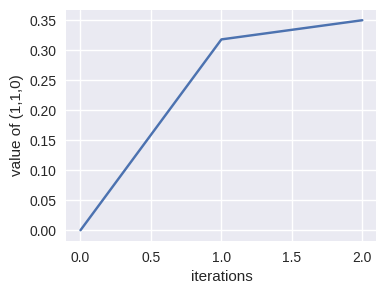

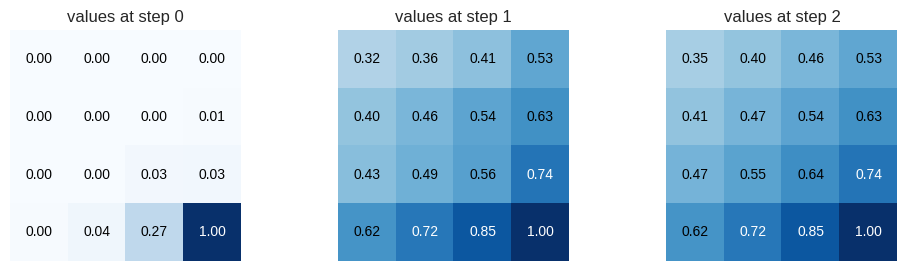

In [47]:
visible_env.play()

visualize(MPI_planner.V_logs, (1, 1, 1), 6)

### Value Iteration (VI) Recap

**Idea**

Gradually advance to $\pi^{*}$ with combined **truncated policy evaluation** and **policy improvement** steps.

&nbsp;

**Truncated Policy Evaluation and Improvement step**

No arbitrary starting policy needed. Estimate $V^{\pi^*}$ as follows:

  * For $k = 0,1,2,\cdots, K$

    * Set $V = \mathbf{0}$ when $k = 0$ and $V_{k-1}$ otherwise
      <div>
      <img src="https://drive.google.com/uc?export=view&id=1fsi3ZZgqZ-p061AxvSdeluWZTlwSjnGj" alt="policy evaluation and improvement" width="400"/>
      </div>

      return $V$ as $V_{k}$.


&nbsp;

#### Putting everything together

* Estimate $V^{\pi^*}$ with $V_{K} = (T^*)^{K}\mathbf{0}$
* Return $\hat{\pi}^{*}$ as the greedy policy w.r.t $V_{K}$. That is,

  $$ \hat{\pi}^{*}(s) \in \underset{a\in\mathcal{A}}{\arg\max} \bigg\{r(s,a) + \gamma\sum_{s'\in\mathcal{X}}p(s'|s,a)V_{K}(s')\bigg\},\quad s\in\mathcal{S}$$



&nbsp;

#### Theoretical guarantee [[2]](#scrollTo=XqJPFe6f6gFV&line=5&uniqifier=1)

VI finds an **$\mathbf{\varepsilon}$-optimal policy** ($\pi^{\varepsilon}$) satisfying

$\qquad V^* - V^{\pi^{\varepsilon}}\leq \varepsilon\,\mathbf{1}$

after $K = \mathcal{O}(\ln(2\gamma/\varepsilon(1-\gamma)^2)/(1-\gamma))$ iterations.


In [48]:
class ValueIteration:
  """
  Implements value iteration
  """
  def __init__(self,
              env: Env,
              gamma: float,
              epsilon: float,
              num_iterations = None,
  ):
    self.env = env
    self.states = self.env.states
    self.n_states = len(self.states)
    self.actions = self.env.actions
    self.n_actions = len(self.actions)
    self.gamma = gamma
    self.K = num_iterations
    self.V_logs = []

    if self.K is None:
      self.K = math.ceil(np.log((2*self.gamma)/(epsilon*(1-self.gamma)**2))/(1-self.gamma))

    self.policy = {state: 0 for state in self.env.states}
    self.V = {state: 0 for state in self.env.states}


  def estimate_vstar(self):
    """
    Starting from an initial guess 'V',
    iteratively estimate V^{π*} as T*V

    Assign new values to self.V
    """
    # Task: Complete this and delete line *

    # Main loop for iterative value update
    for k in range(self.K):
      for state in self.states:
        a_s = []
        for a in self.actions:
          sum_ = 0
          for s_next in self.states:
            sum_ += self.env.T[state][a][s_next] * (self.env.R[state][a] + self.gamma * self.V[s_next])
          a_s.append(sum_)
        self.V[state] = max(a_s)


    self.V_logs.append(self.V.copy())


  def get_policy(self):
    """
    Get the greedy policy:
      π(s) = argmax_{a\in A} Q(s,a)
    where
      Q(s,a) = r(s,a) + gamma*<P(.|s,a),v>

    assign new policy to self.policy
    """
    return PolicyIteration.get_policy(self)


  def get_expected_update(self, state, action):
    """
    Compute:

      Q(s,a) = r(s,a) + gamma <p(.|s,a),V>

    :param state
    :param action

    :return Q(s,a): float
    """
    return PolicyIteration.get_expected_update(self, state, action)

Finally, we also plan with Value Iteration.

In [49]:
VI_planner = ValueIteration(env,
                            gamma = 0.9, #same as PI
                            epsilon = 0.01,
                            num_iterations = None) # You can set the number of iterations

VI_planner.estimate_vstar()
VI_planner.get_policy()

In [50]:
avg_return = rollouts(env=visible_env,
                      policy=make_policy(VI_planner.policy),
                      n_trajectories=80,
                      gamma=0.9)

print(avg_return)

0.3476792496898552


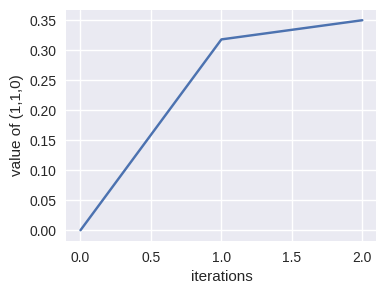

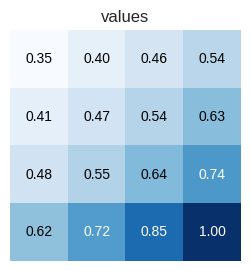

In [51]:
visible_env.play()

visualize(VI_planner.V_logs, (1, 1, 0), 6)

### Bonus Task ⭐

Implement Optimistic Policy Iteration. See slide 33 of [[1]](#scrollTo=XqJPFe6f6gFV&line=5&uniqifier=1).

Improve the efficiency of the implementations above with Numpy/Pytorch/Tensorflow.

# Credit:

1.   Bruno Scherrer, "a lecture on Markov Decision Processes and Dynamic Programming", June 2023, [Slides](https://drive.google.com/file/d/1sFh0TyU_nq60R7kouPg6MCI4IMYicSII/view?usp=sharing)
2.   Csaba Szepesvári "a lecture series on Theoretical Foundations of Reinforcement Learning", 2020, [RL Theory course](https://rltheory.github.io/)
3.   Richard S. Sutton, Andrew G. Barto "Reinforcement Learning: An Introduction", second edition, 2020, [Book](http://incompleteideas.net/book/RLbook2020.pdf)



